# Factors Affecting Carbon Export in the Global Ocean

### Research Computing Final Project

### Annie Leal

The general scope of this project is to explore the factors which affect carbon export in the ocean. Carbon export ($F(POC)_{ex}$) is defined as the process by which carbon, which has been incorporated into biomass in the surface ocean through photosynthesis, is transported to the deep ocean. This process effectively sequesters the carbon from the atmosphere and has a large effect on atmospheric CO$_{2}$ concentrations. There are many factors which determine the proportion of fixed carbon that sinks out of the surface ocean. Here, we will examine how net primary productivity ($NPP$) and surface nutrients impact carbon export in addition to evaluating some satellite based estimates of $F(POC)_{ex}$. 

For this project, carbon export will functionally be defined as carbon that sinks deeper than the euphotic zone.

In [1]:
# Install and import relevant packages

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy
import pooch

### 1. SIMPLE-TRIM carbon export model

This first dataset is a carbon export model output that is based on assimilated satellite and tracer data. It takes regional community composition into account along with the standard NPP and temperature measurements. 

In [2]:
# load and clean the dataset

simple_trim_url = 'http://tdevries.eri.ucsb.edu/wp-content/uploads/2018/03/SIMPLE_TRIM_output.nc'

file_path = pooch.retrieve(url=simple_trim_url,
                          known_hash='md5:75487e25bfe7448736883a26b697ba81')

trim = xr.open_dataset(file_path).load()
trim = trim.set_coords(['LAT', 'LON'])
trim['longitude'] = ((trim.longitude)*2)
trim['latitude'] = ((trim.latitude-45)*2)
#trim['POCfluxobs'] = trim.POCfluxobs.where(trim.POCfluxobs != -9.999)
trim = trim.where(trim != -9.999)
trim

<xarray.Dataset>
Dimensions:      (depth: 24, longitude: 180, latitude: 91, version: 12)
Coordinates:
    LAT          (depth, longitude, latitude) float64 -89.01 -87.03 ... 89.01
    LON          (depth, longitude, latitude) float64 1.0 1.0 ... 359.0 359.0
  * longitude    (longitude) int64 0 2 4 6 8 10 12 ... 348 350 352 354 356 358
  * latitude     (latitude) int64 -90 -88 -86 -84 -82 -80 ... 80 82 84 86 88 90
Dimensions without coordinates: depth, version
Data variables: (12/51)
    mask         (depth, longitude, latitude) float64 0.0 0.0 0.0 ... 0.0 0.0
    DEPTH        (depth, longitude, latitude) float64 18.07 18.07 ... 5.433e+03
    Volume       (depth, longitude, latitude) float64 3.051e+10 ... 5.348e+11
    Area         (longitude, latitude) float64 8.443e+08 2.532e+09 ... 8.443e+08
    NPP          (version, longitude, latitude) float64 0.0 0.0 ... 30.44 0.0
    Zeu          (depth, longitude, latitude) float64 nan nan nan ... 12.69 nan
    ...           ...
    k_SL         (version) float64 0.5202 0.3849 0.4704 ... 0.1846 0.4463 0.282
    k_SR         (version) float64 0.009652 0.003778 ... 0.008886 0.003197
    k_R          (version) float64 4.935e-05 1.341e-05 ... 4.586e-05 1.134e-05
    npp_version  (version) float64 0.0 1.0 0.0 1.0 0.0 ... 1.0 0.0 1.0 0.0 1.0
    phistar      (version) float64 1.0 1.0 0.5 0.5 2.0 ... 1.0 0.5 0.5 2.0 2.0
    mind_large   (version) float64 5.0 5.0 5.0 5.0 5.0 ... 20.0 20.0 20.0 20.0

Visualize global $NPP$ and measured $F(POC)_{ex}$ from this dataset.

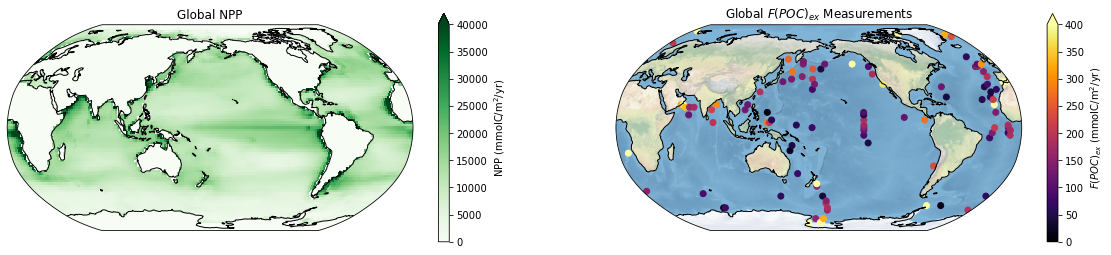

In [3]:
plot_proj = ccrs.Robinson(central_longitude=180)

fig, ax = plt.subplots(figsize=(20,14), ncols=2, subplot_kw={'projection': plot_proj})

# Plot NPP
NPP_plot = trim.NPP.mean(axis=0).plot(x='longitude', y='latitude', transform=ccrs.PlateCarree() ,ax=ax[0], vmin=0, vmax=40000, add_colorbar=False, cmap='Greens')
ax[0].add_feature(cartopy.feature.COASTLINE, edgecolor='black')
ax[0].set_title('Global NPP')
cb_1 = plt.colorbar(NPP_plot, ax=ax[0], shrink=0.3, extend='max')
cb_1.set_label('NPP (mmolC/m$^{2}$/yr)')

# Change dimensions of the observed F(POC) array
trim['FPOC_ex_obs'] = trim.POCfluxobs.max(axis=0)

# Plot F(POC)ex
FPOCobs_plot = xr.plot.scatter(x='longitude', y='latitude', ds=trim, hue='FPOC_ex_obs', transform=ccrs.PlateCarree(), vmin=0, vmax=400, ax=ax[1], add_guide=False, cmap='inferno')
ax[1].add_feature(cartopy.feature.COASTLINE, edgecolor='black')
ax[1].set_title('Global $F(POC)_{ex}$ Measurements')
ax[1].stock_img()
cb_2 = plt.colorbar(FPOCobs_plot, ax=ax[1], shrink=0.3, extend='max')
cb_2.set_label('$F(POC)_{ex}$ (mmolC/m$^{2}$/yr)')

### Laws Algorithm carbon export calculation

The Laws Algorithtm for carbon export as described in Laws et al. 2011 is a mathematical relationship that estimates the fraction of carbon exported ($ef$) based on sea surface temperature ($SST$) and $NPP$. This fraction can then be multiplied by $NPP$ to get $F(POC)_{ex}$. Using this method removes any dependence on regional community structure differences in the estimate and reduces this to a first-order problem.

$ef = 0.04756 * (0.78 - (0.43* \frac{SST}{30})) (\frac{NPP}{12})^{0.307}$

$F(POC)_{ex} = NPP * ef$

In [4]:
SST = trim.Temp.where(trim.DEPTH < 20).mean(axis=0)
NPP = trim.NPP.mean(axis=0)

ef = 0.04756 * (0.78 - (0.43 * SST / 30)) * (NPP/12)**0.307
trim['laws'] = ef * NPP
trim.laws

<xarray.DataArray 'laws' (longitude: 180, latitude: 91)>
array([[       nan,        nan,        nan, ..., 1.54890976, 1.55220212,
               nan],
       [       nan,        nan,        nan, ..., 1.54500838, 1.55052795,
               nan],
       [       nan,        nan,        nan, ..., 1.54204749, 1.54923625,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 1.55451695, 1.55442405,
               nan],
       [       nan,        nan,        nan, ..., 1.55376349, 1.55440108,
               nan],
       [       nan,        nan,        nan, ..., 1.55186237, 1.5536595 ,
               nan]])
Coordinates:
  * longitude  (longitude) int64 0 2 4 6 8 10 12 ... 346 348 350 352 354 356 358
  * latitude   (latitude) int64 -90 -88 -86 -84 -82 -80 ... 80 82 84 86 88 90

### Comparison of the two estimates of carbon export

Visualize the two methods side by side.

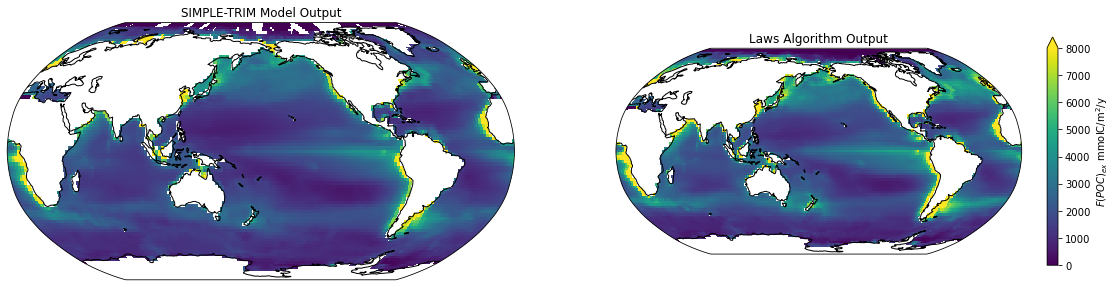

In [5]:
fig, ax = plt.subplots(figsize=(20,14), ncols=2, subplot_kw={'projection': plot_proj})

# Plot SIMPLE-TRIM Output
trim_export = trim.FPOCex.mean(axis=0).plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(), vmin=0, vmax=8000, ax=ax[0], add_colorbar=False)
ax[0].add_feature(cartopy.feature.COASTLINE, edgecolor='black')
ax[0].set_title('SIMPLE-TRIM Model Output')

# Plot Laws Algorithm result
laws_plot = trim.laws.plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(), ax=ax[1], vmin=0, vmax=8000, add_colorbar=False)
ax[1].add_feature(cartopy.feature.COASTLINE, edgecolor='black')
ax[1].set_title('Laws Algorithm Output')
cb = fig.colorbar(laws_plot, shrink=0.3, extend='max')
cb.set_label('$F(POC)_{ex}$ mmolC/m$^{2}$/y')


In the above figures, it appears that the Laws Algorithm yields higher carbon export values in the margin proximal regions at low latitudes. Both agree well in the Southern Ocean and gyre regions in all ocean basins. The region with the most apparent difference between these two estimates lies north of 70 $^{\circ}$N. The first thing to note is missing data in the SIMPLE_TRIM output. However, this is likely an artifact of a lack of data or the presence of sea ice, and this can be disregarded. Additionally, there seem to be higher fluxes in some of the high latitude northern seas.

Let us quantify the differences between these two $F(POC)_{ex}$ estimates by taking their difference.

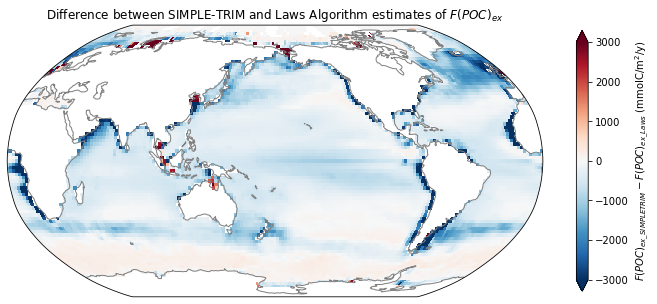

In [6]:
diff = trim.FPOCex.mean(axis=0) - trim.laws

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))

diff_plot = diff.plot(x='longitude', y='latitude', transform=ccrs.PlateCarree() ,ax=ax, vmin=-3000, vmax=3000, add_colorbar=False, cmap='RdBu_r')
ax.add_feature(cartopy.feature.COASTLINE, edgecolor='grey')

ax.set_title('Difference between SIMPLE-TRIM and Laws Algorithm estimates of $F(POC)_{ex}$')
cb = plt.colorbar(diff_plot, ax=ax, shrink=0.8, extend='both')
cb.set_label('$F(POC)_{ex\_SIMPLETRIM} - F(POC)_{ex\_Laws}$ (mmolC/m$^{2}$/y)')

# Laws has higher estimates at low latitudes, especially in near margin regions and near the ITCZ
# SIMPLE-TRIM has higher estimates at high latitudes, especially in high latitude seas

From this figure, we see that the SIMPLE-TRIM model has slightly higher estimates of $F(POC)_{ex}$ at high latitudes. It also has much higher estimates at high latitude ses where there is deep or bottom water formation. This model takes into account community structure as well as tracer data, so could nutrient upwelling from the deep convective mixing result in higher $F(POC)_{ex}$ values? We will come back to this question later.

Let us now compare these estimates to observed particulate organic carbon fluxes ($F(POC)$)

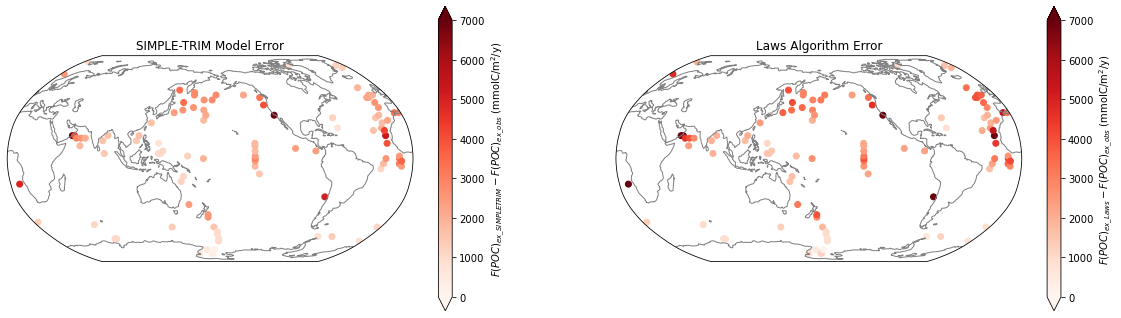

In [35]:
trim['simple_obs'] = trim.FPOCex.mean(axis=0) - trim.FPOC_ex_obs
trim['laws_obs'] = trim.laws - trim.FPOC_ex_obs

fig, ax = plt.subplots(figsize=(20, 14), ncols=2, subplot_kw={'projection':plot_proj})

simple_plot = xr.plot.scatter(x='longitude', y='latitude', ds=trim, hue='simple_obs', transform=ccrs.PlateCarree(), vmin=0, vmax=7000, ax=ax[0], add_guide=False, cmap='Reds')
ax[0].add_feature(cartopy.feature.COASTLINE, edgecolor='grey')
ax[0].set_title('SIMPLE-TRIM Model Error')
cb_1 = plt.colorbar(simple_plot, ax=ax[0], shrink=0.4, extend='both')
cb_1.set_label('$F(POC)_{ex\_SIMPLETRIM} - F(POC)_{ex\_obs}$ (mmolC/m$^{2}$/y)')


laws_plot = xr.plot.scatter(x='longitude', y='latitude', ds=trim, hue='laws_obs', transform=ccrs.PlateCarree(), vmin=0, vmax=7000, ax=ax[1], add_guide=False, cmap='Reds')

ax[1].add_feature(cartopy.feature.COASTLINE, edgecolor='grey')
ax[1].set_title('Laws Algorithm Error')
cb_2 = plt.colorbar(laws_plot, ax=ax[1], shrink=0.4, extend='both')
cb_2.set_label('$F(POC)_{ex\_Laws} - F(POC)_{ex\_obs}$ (mmolC/m$^{2}$/y)')


SIMPLE-TRIM agrees more with the observed data. Moving forward we will use this model estimate.

## Load GEOTRACES TEI data

In [8]:
dropbox_url = 'https://dl.dropboxusercontent.com/s/e9u1bwz5d0izspe/GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1.nc?dl=0'

file_path = pooch.retrieve(url=dropbox_url,
                           known_hash='md5:82e4a35dd37b78474c8c30346b31387d')
file_path

'/home/jovyan/.cache/pooch/ed71d9f3b0cf0046dc6061e8860e4f9c-GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1.nc'

In [9]:
tei = xr.open_dataset(file_path)

tei = tei.rename({
    'N_STATIONS':'station',
    'N_SAMPLES':'depth',
    'metavar1':'cruise',
    'metavar2':'stn',
    'var2':'z', 
    'var4':'GEOTRACES_ID',
    'latitude':'LAT',
    'longitude':'LON',
    
    'var332':'Ba_TP',
    'var329':'Al_TP',
    'var361':'Ti_TP',
    'var475':'Th230_SSF',
    'var476':'Th230_LSF',
    'var454':'POC_LSF',
    'var455':'POC_SSF',
    'var37':'phosphate',
    'var40':'nitrate',
    'var42':'nitrite',
    'var88':'dFe'
})

tei = tei.set_coords(['z', 'cruise', 'stn', 'LAT', 'LON'])
tei['cruise'] = tei['cruise'].astype(str)
tei


<xarray.Dataset>
Dimensions:       (station: 3149, depth: 698)
Coordinates:
    cruise        (station) <U6 'GA01' 'GA01' 'GA01' ... 'GSc02' 'GSc02' 'GSc02'
    stn           (station) |S26 ...
    LON           (station) float32 ...
    LAT           (station) float32 ...
    z             (station, depth) float32 ...
Dimensions without coordinates: station, depth
Data variables: (12/1583)
    metavar3      (station) |S1 ...
    metavar4      (station) float32 ...
    metavar5      (station) |S13 ...
    metavar6      (station) |S20 ...
    metavar7      (station) |S23 ...
    metavar8      (station) |S31 ...
    ...            ...
    var582        (station, depth) float32 ...
    var582_qc     (station, depth) float32 ...
    var583        (station, depth) float32 ...
    var583_qc     (station, depth) float32 ...
    var584        (station, depth) float32 ...
    var584_qc     (station, depth) float32 ...
Attributes:
    Conventions:         CF-1.7
    comment:             ODV NetCDF Export File V2.0
    Creator:             rschlitz@BGEO04M097-1
    CreateTime:          2021-11-11T08:45:54
    Software:            Ocean Data View 5.5.2 - 64 bit (Windows)
    source:              C:/GEOTRACES/IDP2021/output/data/seawater/GEOTRACES_...
    SourceLastModified:  2021-11-09T15:31:14
    DataField:           Ocean
    DataType:            Profiles
    Description:         GEOTRACES IDP2021 seawater discrete sample hydrograp...
    featureType:         profile

In [10]:
surface_data = xr.merge([
    tei.phosphate.sel(depth=0),
    tei.nitrate.sel(depth=0),
    tei.nitrite.sel(depth=0),
    tei.dFe.sel(depth=0)
], join='outer')
surface_data

<xarray.Dataset>
Dimensions:    (station: 3149)
Coordinates:
    cruise     (station) <U6 'GA01' 'GA01' 'GA01' ... 'GSc02' 'GSc02' 'GSc02'
    stn        (station) |S26 b'0' b'1' b'2' b'3' ... b'11' b'12' b'13' b'15'
    LON        (station) float32 349.3 350.0 350.5 350.4 ... 190.0 190.0 186.1
    LAT        (station) float32 38.43 40.33 40.33 ... -57.15 -56.18 -53.96
    z          (station) float32 2.957e+03 3.0 6.0 3.0 ... 25.4 25.7 24.9 24.8
Dimensions without coordinates: station
Data variables:
    phosphate  (station) float32 ...
    nitrate    (station) float32 ...
    nitrite    (station) float32 ...
    dFe        (station) float32 ...
Attributes:
    long_name:            PHOSPHATE_D_CONC_BOTTLE
    units:                umol/kg
    comment:              Concentration of dissolved phosphate, samples may o...
    ancillary_variables:  var37_qc var37_err
    C_format:             %.3f
    FORTRAN_format:       F12.3

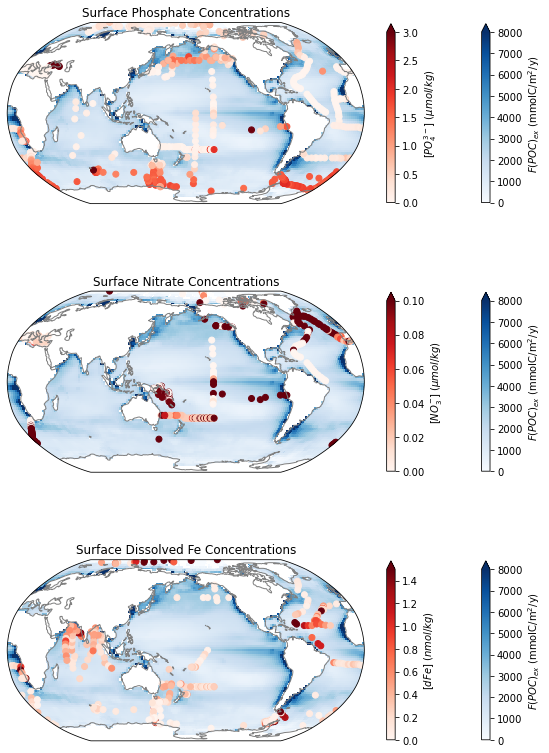

In [61]:
fig, ax = plt.subplots(figsize=(10,14), nrows=3, subplot_kw={'projection': plot_proj})

trim_export = trim.FPOCex.mean(axis=0).plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(), vmin=0, vmax=8000, ax=ax[0], add_colorbar=False, cmap='Blues')
phos = surface_data.plot.scatter(x='LON', y='LAT', hue='phosphate', transform=ccrs.PlateCarree(), ax=ax[0], vmin=0, vmax=3, add_guide=False, cmap='Reds')
ax[0].add_feature(cartopy.feature.COASTLINE, edgecolor='grey')
ax[0].set_title('Surface Phosphate Concentrations')
plt.colorbar(trim_export, ax=ax[0], shrink=0.8, extend='max', label='$F(POC)_{ex}$ (mmolC/m$^{2}$/y)')
plt.colorbar(phos, ax=ax[0], shrink=0.8, extend='max', label='[$PO_{4}^{3-}$] ($\mu mol/kg$)')


trim_export = trim.FPOCex.mean(axis=0).plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(), vmin=0, vmax=8000, ax=ax[1], add_colorbar=False, cmap='Blues')
nit = surface_data.plot.scatter(x='LON', y='LAT', hue='nitrate', transform=ccrs.PlateCarree(), ax=ax[1], vmin=0, vmax=0.1, add_guide=False, cmap='Reds')
ax[1].add_feature(cartopy.feature.COASTLINE, edgecolor='grey')
ax[1].set_title('Surface Nitrate Concentrations')
plt.colorbar(trim_export, ax=ax[1], shrink=0.8, extend='max', label='$F(POC)_{ex}$ (mmolC/m$^{2}$/y)')
plt.colorbar(nit, ax=ax[1], shrink=0.8, extend='max', label='[$NO_{3}^{-}$] ($\mu mol/kg$)')


trim_export = trim.FPOCex.mean(axis=0).plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(), vmin=0, vmax=8000, ax=ax[2], add_colorbar=False, cmap='Blues')
dfe = surface_data.plot.scatter(x='LON', y='LAT', hue='dFe', transform=ccrs.PlateCarree(), ax=ax[2], vmin=0, vmax=1.5, add_guide=False, cmap='Reds')
ax[2].add_feature(cartopy.feature.COASTLINE, edgecolor='grey')
ax[2].set_title('Surface Dissolved Fe Concentrations')
plt.colorbar(trim_export, ax=ax[2], shrink=0.8, extend='max', label='$F(POC)_{ex}$ (mmolC/m$^{2}$/y)')
plt.colorbar(dfe, ax=ax[2], shrink=0.8, extend='max', label='[$dFe$] ($nmol/kg$)')

In [ ]:
Note the sampling bias.